In [18]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.widgets import Button
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.image as image
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from IPython.display import display, Markdown, clear_output
import matplotlib.ticker as mtick

pd.options.mode.chained_assignment = None

In [19]:
#data preprocessing
matches = pd.read_csv("premier_league_matches.csv")

#append 'result' column, identifying whether the home team won, tied, or lost
matches.loc[matches['home_ft_score'] > matches['away_ft_score'], 'result'] = 'W'
matches.loc[matches['home_ft_score'] == matches['away_ft_score'], 'result'] = 'T'
matches.loc[matches['home_ft_score'] < matches['away_ft_score'], 'result'] = 'L'

#replace home score and away score with 'score' column
matches['score'] = matches['home_ft_score'].astype(str) +"-"+ matches["away_ft_score"].astype(str)

#select a specific subset of columns in dataframe
matches = matches[['date','home_team','away_team','score','result','home_shots_on_target',
                    'home_shots','home_fouls_conceded']].reset_index(drop=True)

#add dummy row for Norwich City
matches.loc[len(matches.index)] = ['2020-08-09','Norwich City','Watford','4-1','W',12,9,7] 

#split dataframe into two datasets: one containing matches with fans, one containing matches without fans
fans_matches = matches.loc[matches['date'] < '2020-06-17'].reset_index(drop=True)
nofans_matches = matches.loc[matches['date'] >= '2020-07-11'].reset_index(drop=True)

home_fans = pd.DataFrame()
home_nofans = pd.DataFrame()

home_fans['Teams'] = fans_matches['home_team'].unique()
home_nofans['Teams'] = nofans_matches['home_team'].unique()

home_fans = home_fans.sort_values(by=['Teams'], ascending=True).reset_index(drop=True)
home_nofans = home_nofans.sort_values(by=['Teams'], ascending=True).reset_index(drop=True)

home_fans['Home Wins'] = 0
home_fans['Shots Ratio'] = 0
home_fans['Home Games'] = 0
home_fans['Home Fouls / Game'] = 0

home_nofans['Home Wins'] = 0
home_nofans['Shots Ratio'] = 0
home_nofans['Home Games'] = 0
home_nofans['Home Fouls / Game'] = 0

for ind in home_fans.index:
    group_1f = fans_matches.groupby(['home_team','result'])
    group_2f = fans_matches.groupby(['home_team'])
    team = group_2f.get_group((home_fans['Teams'][ind]))

    home_fans['Home Wins'][ind] = len(group_1f.get_group((home_fans['Teams'][ind], 'W')))
    home_fans['Home Games'][ind] = len(team)
    home_fans['Shots Ratio'][ind] = team['home_shots'].sum() / len(team)
    home_fans['Home Fouls / Game'][ind] = team['home_fouls_conceded'].sum() / len(team)

for ind in home_nofans.index:
    group_1nf = nofans_matches.groupby(['home_team','result'])
    group_2nf = nofans_matches.groupby(['home_team'])
    team = group_2nf.get_group((home_nofans['Teams'][ind]))

    home_nofans['Home Wins'][ind] = len(group_1nf.get_group((home_nofans['Teams'][ind], 'W')))
    home_nofans['Home Games'][ind] = len(group_2nf.get_group((home_nofans['Teams'][ind])))
    home_nofans['Shots Ratio'][ind] = team['home_shots'].sum() / len(team)
    home_nofans['Home Fouls / Game'][ind] = team['home_fouls_conceded'].sum() / len(team)
    
home_fans['Win Ratio'] = home_fans['Home Wins'] / home_fans['Home Games']
home_nofans['Win Ratio'] = home_nofans['Home Wins'] / home_nofans['Home Games']

#remove norwich, bournemouth, watford, fulham, West Bromwich Albion, Leeds United
drop_teams = ['AFC Bournemouth', 'Norwich City', 'Watford', 'Fulham', 'West Bromwich Albion', 'Leeds United']
home_fans = home_fans[(home_fans.Teams.isin(drop_teams) == False)].reset_index(drop=True)
home_nofans = home_nofans[(home_nofans.Teams.isin(drop_teams) == False)].reset_index(drop=True)

home_fans['Win Change'] = round(((home_fans['Win Ratio'] - home_nofans['Win Ratio']) / home_nofans['Win Ratio'])*100,1)
home_fans['Shots Change'] = round(((home_fans['Shots Ratio'] - home_nofans['Shots Ratio']) / home_nofans['Shots Ratio'])*100,1)
home_fans['Fouls Change'] = round(((home_fans['Home Fouls / Game'] - home_nofans['Home Fouls / Game']) / home_nofans['Home Fouls / Game'])*100,1)


In [153]:
home_nofans

,Teams,Home Wins,Shots Ratio,Home Games,Home Fouls / Game,Win Ratio
0,Arsenal,8,11.875000,16,10.312500,0.500000
1,Aston Villa,7,14.571429,14,12.500000,0.500000
2,Brighton and Hove Albion,1,14.312500,16,11.687500,0.062500
3,Burnley,4,9.470588,17,10.117647,0.235294
4,Chelsea,9,15.375000,16,11.562500,0.562500
5,Crystal Palace,5,8.411765,17,10.647059,0.294118
6,Everton,5,10.062500,16,10.812500,0.312500
7,Leicester City,8,12.687500,16,11.312500,0.500000
8,Liverpool,8,16.000000,17,10.235294,0.470588
9,Manchester City,14,16.666667,18,9.277778,0.777778


interactive(children=(Dropdown(description='Data', options=('Home Win Rate', 'Shots Per Home Game', 'Fouls Per…

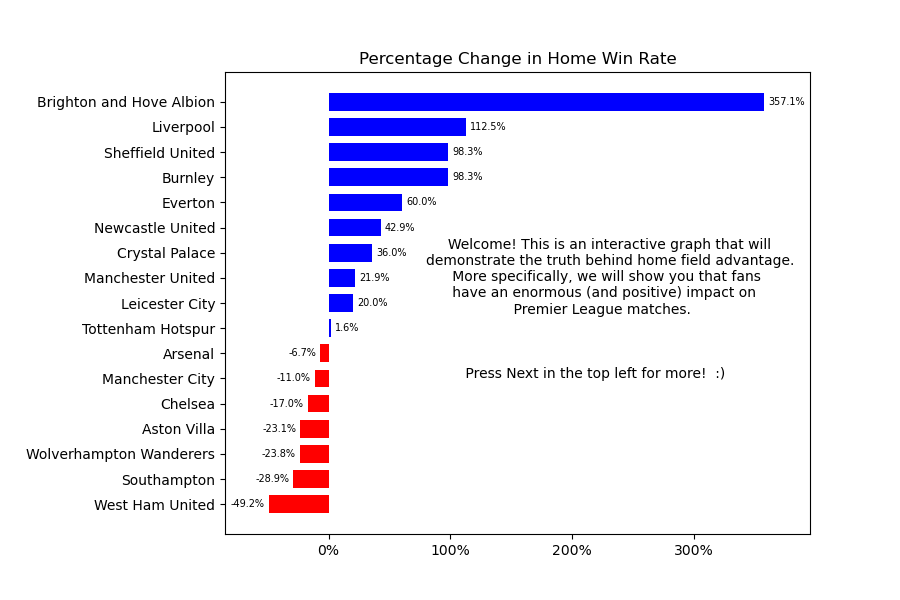

In [211]:
%matplotlib widget

button = widgets.Button(description='Next')
out = widgets.Output()

class Interact:

    
    ind = np.arange(17)
    width = 0.7
    data = home_fans['Win Change']
    fig, ax = plt.subplots()
    
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    
    home_fans = home_fans.sort_values('Win Change', ascending=True)
    bar = ax.barh(ind, data, width, color=['blue','blue','blue','blue','blue','blue','blue',
                                            'blue','blue','blue','red','red','red','red','red','red', 'red'])
    ann = ax.annotate('',(1,10))
    fig.set_size_inches(9, 6)
        
    spacing = 0.25
    fig.subplots_adjust(left=spacing)
        
    number = 1
    index = 0
    texts = []
    pics = []
    imagebox = ''
    ab = ''

    def updateText(self):
        self.ann.set_text('')
        if self.number == 1:
            self.texts = [('     Welcome! This is an interactive graph that will'
                           '\ndemonstrate the truth behind home field advantage.'
                           '\n      More specifically, we will show you that fans '
                           '\n      have an enormous (and positive) impact on '
                           '\n                    Premier League matches.'
                           '\n\n\n\n         Press Next in the top left for more!  :)', (80,5)),
                          ('The dropdown menu above the "Next" button'
                           '\nwill allow you to select one of three graphs'
                           '\n  to investigate. Click the "Next" button to'
                           '\nlearn more about the current graph, or click '
                           '\non one of the other graphs in the dropdown!', (80,7)),
                          ('      Hmmmm... This seems like a pretty important graph!'
                           '\n       It looks like most teams saw a higher home win rate.' 
                           '\n           Brighton even had a whopping 357% increase!!'
                           '\n            What could have caused such a huge change???',(20, 2)),
                          ('       It\'s all because of the fans of course!!'
                           '\n   This graph depicts the change in win rate between'
                           '\n  a season without fans and a season with fans in the'
                           '\n    stadium. We can clearly see that most teams won'
                           '\nsignificantly more at home during the season with fans!!', (20,2))]

            self.pics = [0,0,(image.imread('emoji.jpeg'),(250,10),1),(image.imread('fans.jpeg'),(250, 10),0.8)]

        elif self.number == 2:
            self.texts = [('It seems that there are far fewer fouls'
                          '\nconceded by the home team when fans'
                          '\nare in the stadium. Why might that be?'
                          '\n            (Press Next to find out!)',(-.3, 12)),
                     ('The dropdown menu above the "Next" button'
                      '\n will allow you to select one of three graphs'
                      '\n to investigate. The "Next" button will guide'
                      '\nyou through a veryof each '
                        '\nmore with fans in the'
                        '\nstadium than without...',(.23, 9.7)), ('Possibly because ',(.2, 10))]

            self.pics = [0,(image.imread('Shots.jpeg'),(0.3, 4),0.6),0]

        else:
            self.texts = [('It seems that there are far fewer fouls'
                          '\nconceded by the home team when fans'
                          '\nare in the stadium. Why might that be?'
                          '\n            (Press Next to find out!)',(-31, 12)),('Teams conceded far'
                '\nfewer fouls with the'
                '\ncrowd roaring... ',(-31, 6)), ('Probably because'
                '\nthe ref was scared of'
                '\nangering the fans! ',(3.5, .7))]

            self.pics = [0,0,(image.imread('referee.jpeg'),(10.5, 7),0.5),0]

        self.index = 0    
    
    
    def click(self):
        self.index += 1

        with out:
            # what happens when we press the button
            print(self.index)

            if (self.index > len(self.texts)):
              # If it is, point back at the beginning of the list
                self.index = 1
                if self.ab != '':
                    self.ab.remove()
                    self.ab = ''
                    print(self.ab)

                print(self.index)
            
            self.ann.set_text(self.texts[self.index-1][0])
            self.ann.set_position(self.texts[self.index-1][1])
            plt.draw()
            
            if self.pics[self.index-1] == 0:
                print('hi')
                if self.index >= 2 and self.ab != '':
                    self.ab.remove()
                else:
                    print('hello!')
            else:
                print('uh oh')
                pic = self.pics[self.index-1][0]
                self.imagebox = OffsetImage(pic, zoom = self.pics[self.index-1][2])
                self.ab = AnnotationBbox(self.imagebox, self.pics[self.index-1][1], frameon = False)
                self.ax.add_artist(self.ab)

            
    def on_button_clicked(self,_):
          # "linking function with output"
        self.click()
            
    def my_function2(self,Data):

        if Data == 'Home Win Rate':
            plt.cla()
            self.number = 1

            self.home_fans = self.home_fans.sort_values('Win Change', ascending=True)
            self.data = self.home_fans['Win Change']

            self.bar = self.ax.barh(self.ind, self.data, self.width, color=['red','red','red','red','red','red','red',
                                                'blue','blue','blue','blue','blue','blue','blue','blue','blue', 'blue'])

            plt.title('Percentage Change in Home Win Rate')
            
            fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
            xticks = mtick.FormatStrFormatter(fmt)
            self.ax.xaxis.set_major_formatter(xticks)
            
            self.ax.set(yticks=self.ind, yticklabels=self.home_fans['Teams'])
            self.ax.set_xticks(self.ax.get_xticks()[::2])

            for bars in self.ax.containers:
                self.ax.bar_label(bars, fmt = '%.1f%%', padding = 3, fontsize = 7)
            
            self.ann = self.ax.annotate('',(1,10))
            
            plt.xlim(-85, 395)

        elif Data == 'Shots Per Home Game': 
            plt.cla()
            self.number = 2

            self.home_fans = self.home_fans.sort_values('Shots Change', ascending=True)
            self.data = self.home_fans['Shots Change']

            self.bar = self.ax.barh(self.ind, self.data, self.width, color=['red','red','red','red','blue','blue','blue','blue',
                                                'blue','blue','blue','blue','blue','blue','blue','blue', 'blue'])

            plt.title('Percentage Change in Shots Per Home Game')
            
            fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
            xticks = mtick.FormatStrFormatter(fmt)
            self.ax.xaxis.set_major_formatter(xticks)
            
            self.ax.set(yticks=self.ind, yticklabels=self.home_fans['Teams'])

            for bars in self.ax.containers:
                self.ax.bar_label(bars, fmt = '%.1f%%', padding = 3, fontsize = 7)
                
            self.ann = self.ax.annotate('',(1,10))

            plt.xlim(-12, 46)   

        else:
            plt.cla()
            self.number = 3
            self.home_fans = self.home_fans.sort_values('Fouls Change', ascending=True)
            self.data = self.home_fans['Fouls Change']

            self.bar = self.ax.barh(self.ind, self.data, self.width, color=['red','red','red','red','red','red','red',
                                                'red','red','red','red','red','blue','blue','blue','blue','blue'])

            plt.title('Percentage Change in Fouls Conceded Per Home Game')
            
            fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
            xticks = mtick.FormatStrFormatter(fmt)
            self.ax.xaxis.set_major_formatter(xticks)
            
            self.ax.set(yticks=self.ind, yticklabels=self.home_fans['Teams'])

            for bars in self.ax.containers:
                self.ax.bar_label(bars, fmt = '%.1f%%', padding = 3, fontsize = 7)
                
            self.ann = self.ax.annotate('',(1,10))

            plt.xlim(-36, 22)

        self.updateText()
        self.click()

run = Interact()
interact(run.my_function2, Data = ['Home Win Rate','Shots Per Home Game','Fouls Per Home Game'])

# linking button and function together using a button's method
button.on_click(run.on_button_clicked)
# displaying button and its output together
widgets.VBox([button,out])